In [20]:
# Model Comparisons 
import pandas as pd
import sys
sys.path.append("/Users/rohit.jishtu/Documents/GitHub/NewMachine/Projects/StatsFunctions")
from Corr import *
from Stats import *
from sklearn.metrics import classification_report
from scipy.stats import chi2_contingency
import numpy as np

In [14]:
UnseenData=pd.read_csv('/Users/rohit.jishtu/Documents/GitHub/NewMachine/Projects/ML Projects/Project 7 - Bank Marketing Data/bank/bank.csv',sep=';')
import joblib


# Preprocessing 

In [ ]:
# Convert Unseen Data to Training Data 

outdf_numeric = CalBasicStats(UnseenData,'numeric')
outdf_nonnumeric = CalBasicStats(UnseenData,'Non-numeric')
keys=['y']
Selected =[]
UnseenData['Target'] = UnseenData['y'].apply(lambda x: 1 if x == 'yes' else 0)


outdf_nonnumeric=outdf_nonnumeric[(outdf_nonnumeric['UniqueCounts']>1)]
Columns2=outdf_nonnumeric['ColumnName'].to_list()
selected_cat_features=Columns2
Selected.extend(outdf_numeric['ColumnName'].to_list())
Selected.append('Target')

# print(data.columns)
# print(Selected)

# Modifying data based on selected.
TrainingData=UnseenData[Selected]
for column in selected_cat_features:
    dummy_variables = pd.get_dummies(UnseenData[column], drop_first=True)
    prefix = str(column+'_')
    dummy_variables = dummy_variables.astype(int)
    dummy_variables = dummy_variables.add_prefix(prefix)
    TrainingData = pd.concat([TrainingData , dummy_variables], axis=1)


print(TrainingData.columns)  # Verify the merged data



Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'Target',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'y_yes'],
      dtype='object')


# ML Models 

In [ ]:
# Prepare the features and target
ML_model= joblib.load('/Users/rohit.jishtu/Documents/GitHub/NewMachine/Projects/ML Projects/Project 7 - Bank Marketing Data/BankDtreeModel.joblib')
ML_Features_df=pd.read_csv('/Users/rohit.jishtu/Documents/GitHub/NewMachine/Projects/ML Projects/Project 7 - Bank Marketing Data/MLFeatureList')
ML_Features=ML_Features_df['0'].to_list()


['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [73]:
# Prepare the features and target

Targets = ['Target','y','y_yes']
FeatureList= ML_Features
X=TrainingData[FeatureList] 
Actuals=UnseenData['Target'] 
predictions = ML_model.predict(X)

predictions_ML=predictions
Actuals_ML=Actuals

# # Print Metrics
report = classification_report(Actuals, predictions)
print(f"ML Classification Report:\n\n{report}")


ML Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      4000
           1       0.37      0.78      0.50       521

    accuracy                           0.82      4521
   macro avg       0.67      0.80      0.70      4521
weighted avg       0.90      0.82      0.85      4521



# DL Model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#  Example model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

# Initialize the model
DL_model = SimpleNN(input_size=39)
DL_model.load_state_dict(torch.load('BAnkData_NN_model.pth'))


/var/folders/vr/rvvf5fcn6957xk3723kv68km0000gn/T/ipykernel_53091/3796726115.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DL_model.load_state_dict(torch.load('BAnkDat

SimpleNN(
  (layer1): Linear(in_features=39, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [65]:
TrainingDataDL=TrainingData
DL_Features_df=pd.read_csv('/Users/rohit.jishtu/Documents/GitHub/NewMachine/Projects/DL Projects/PyTorchSeries/FeatureList_df.csv')
DL_Features=DL_Features_df['0'].to_list()

In [84]:
# For DL 

Targets = ['Target','y','y_yes']
FeatureList= DL_Features
X=TrainingData[FeatureList] 
Actuals_Src=UnseenData['Target'] 
X = X.fillna(0)
X = X.to_numpy(dtype=np.float32)  # Convert features to NumPy array
Actuals = torch.tensor(Actuals, dtype=torch.float32).view(-1, 1)
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
# Set the model to evaluation mode
# Evaluate the model
def evaluate_model(model, X_test, Y_test, threshold=0.5):
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test)
        y_pred = (y_pred_prob >= threshold).float()

    return y_pred, y_pred_prob

Predictions_DL, Prediction_Prob = evaluate_model(DL_model, X_tensor, Actuals)
Actuals_DL=Actuals_Src
# # Print Metrics
report = classification_report(Actuals_DL, Predictions_DL)
print(f"DL Classification Report:\n\n{report}")

DL Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4000
           1       0.52      0.23      0.32       521

    accuracy                           0.89      4521
   macro avg       0.71      0.60      0.63      4521
weighted avg       0.86      0.89      0.87      4521



/var/folders/vr/rvvf5fcn6957xk3723kv68km0000gn/T/ipykernel_53091/3438239750.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Actuals = torch.tensor(Actuals, dtype=torch.float32).view(-1, 1)


# Scoring & Metrics From Both Models 

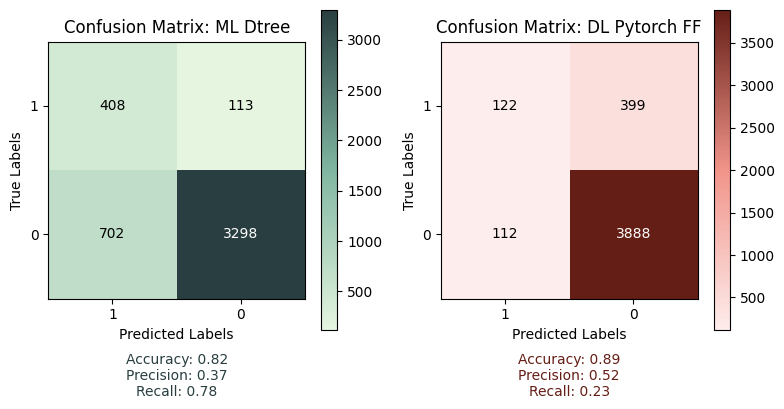

In [91]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def plot_side_by_side_confusion_matrices(y_true, y_pred1, y_pred2, labels=None, model1_name="Model 1", model2_name="Model 2"):
    """
    Plots side-by-side confusion matrices for two models with customized color maps.

    Parameters:
    - y_true: Ground truth labels (array-like)
    - y_pred1: Predictions from the first model (array-like)
    - y_pred2: Predictions from the second model (array-like)
    - labels: List of class labels (optional)
    - model1_name: Name of the first model (string)
    - model2_name: Name of the second model (string)
    """
    # Compute confusion matrices
    cm1 = confusion_matrix(y_true, y_pred1, labels=labels)
    cm2 = confusion_matrix(y_true, y_pred2, labels=labels)

    # Compute metrics
    acc1 = accuracy_score(y_true, y_pred1)
    prec1 = precision_score(y_true, y_pred1, average="binary")
    rec1 = recall_score(y_true, y_pred1, average="binary")

    acc2 = accuracy_score(y_true, y_pred2)
    prec2 = precision_score(y_true, y_pred2, average="binary")
    rec2 = recall_score(y_true, y_pred2, average="binary")

    # Define ServiceNow-inspired custom colormaps
    cmap1 = LinearSegmentedColormap.from_list(
        'model1_cmap', [(0, '#E5F5E0'), (0.5, '#80B6A1'), (1, '#293E40')]
    )
    cmap2 = LinearSegmentedColormap.from_list(
        'model2_cmap', [(0, '#FDEDEC'), (0.5, '#F1948A'), (1, '#641E16')]
    )

    # Define the figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot confusion matrix for the first model
    im1 = axes[0].imshow(cm1, interpolation='nearest', cmap=cmap1)
    axes[0].figure.colorbar(im1, ax=axes[0])
    axes[0].set_title(f"Confusion Matrix: {model1_name}")
    axes[0].set(xticks=range(len(labels)), yticks=range(len(labels)),
                xticklabels=labels, yticklabels=labels,
                xlabel="Predicted Labels", ylabel="True Labels")

    # Add text annotations for the first model
    thresh1 = cm1.max() / 2
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            axes[0].text(j, i, format(cm1[i, j], 'd'), ha="center", va="center",
                         color="white" if cm1[i, j] > thresh1 else "black")

    # Add metrics below the first confusion matrix
    axes[0].text(0.5, -0.3, f"Accuracy: {acc1:.2f}\nPrecision: {prec1:.2f}\nRecall: {rec1:.2f}",
                 transform=axes[0].transAxes, ha="center", va="center", fontsize=10, color="#293E40")

    # Plot confusion matrix for the second model
    im2 = axes[1].imshow(cm2, interpolation='nearest', cmap=cmap2)
    axes[1].figure.colorbar(im2, ax=axes[1])
    axes[1].set_title(f"Confusion Matrix: {model2_name}")
    axes[1].set(xticks=range(len(labels)), yticks=range(len(labels)),
                xticklabels=labels, yticklabels=labels,
                xlabel="Predicted Labels", ylabel="True Labels")

    # Add text annotations for the second model
    thresh2 = cm2.max() / 2
    for i in range(cm2.shape[0]):
        for j in range(cm2.shape[1]):
            axes[1].text(j, i, format(cm2[i, j], 'd'), ha="center", va="center",
                         color="white" if cm2[i, j] > thresh2 else "black")

    # Add metrics below the second confusion matrix
    axes[1].text(0.5, -0.3, f"Accuracy: {acc2:.2f}\nPrecision: {prec2:.2f}\nRecall: {rec2:.2f}",
                 transform=axes[1].transAxes, ha="center", va="center", fontsize=10, color="#641E16")

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming y_true, y_pred1, and y_pred2 are available:
# y_true = [actual class labels]
# y_pred1 = [predicted labels from model 1]
# y_pred2 = [predicted labels from model 2]
# labels = ["Class 0", "Class 1"]
labels = [1,0]
plot_side_by_side_confusion_matrices(Actuals_ML,predictions_ML, Predictions_DL,labels=labels,model1_name="ML Dtree", model2_name="DL Pytorch FF")
